In [62]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [63]:


# Define the ticker symbol and the time frame
ticker_symbol = 'SPY'  # Example for Apple Inc.
start_date = '2010-01-01'
end_date = '2022-12-28'

# Fetch the historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows
data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,87.129951,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,87.360573,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,87.422066,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,87.791122,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,88.083267,126402800


In [64]:
# Calculate daily returns
data['Returns'] = data['Adj Close'].pct_change()

# Calculate the moving averages of the returns
data['MA1'] = data['Returns'].rolling(window=2).mean()
data['MA2'] = data['Returns'].rolling(window=6).mean()

# Compute the mean of the two moving averages
data['MA_Mean'] = np.sqrt(data['MA1']**2 + data['MA2']**2)
data=data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,MA1,MA2,MA_Mean
Date,,,,,,,,,,
2010-01-12,113.970001,114.209999,113.220001,113.660004,87.383659,163333500,-0.009326,-0.003965,0.000495,0.003996
2010-01-13,113.949997,114.940002,113.370003,114.620003,88.121727,161822000,0.008446,-0.000440,0.001462,0.001526
2010-01-14,114.489998,115.139999,114.419998,114.930000,88.360039,115718800,0.002704,0.005575,0.001795,0.005857
2010-01-15,114.730003,114.839996,113.199997,113.639999,87.368256,212283100,-0.011224,-0.004260,-0.000779,0.004331
2010-01-19,113.620003,115.129997,113.589996,115.059998,88.459976,139172700,0.012496,0.000636,0.000749,0.000982


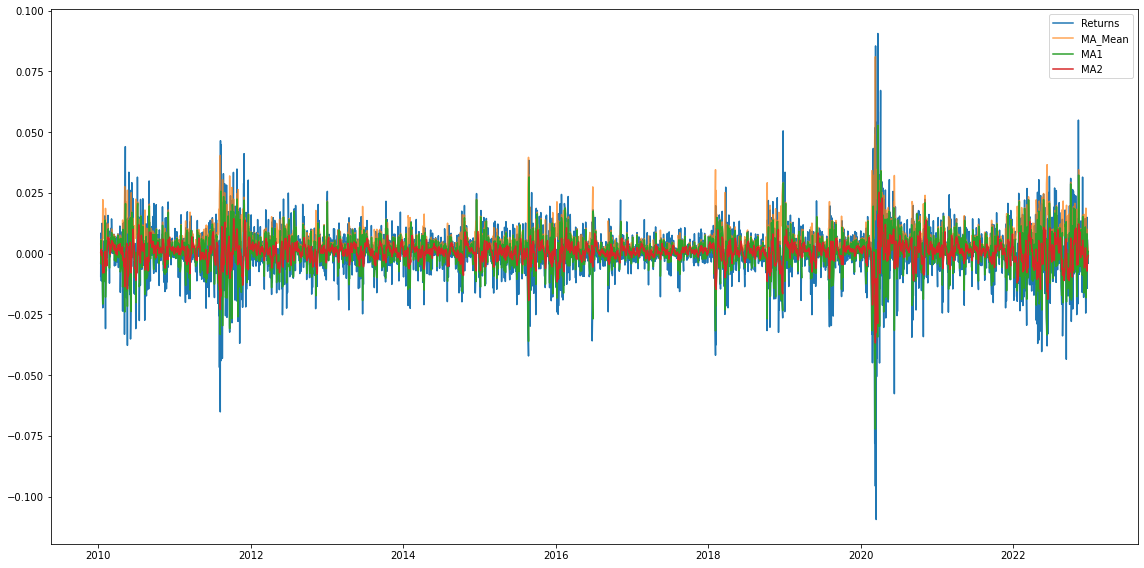

In [65]:
plt.figure(figsize=(16, 8))

# Plotting the closing price and SMA
plt.plot(data['Returns'], label='Returns')
plt.plot(data['MA_Mean'], label='MA_Mean', alpha=0.7)
plt.plot(data['MA1'], label='MA1', )
plt.plot(data['MA2'], label='MA2',)

plt.legend()

plt.tight_layout()
plt.show()


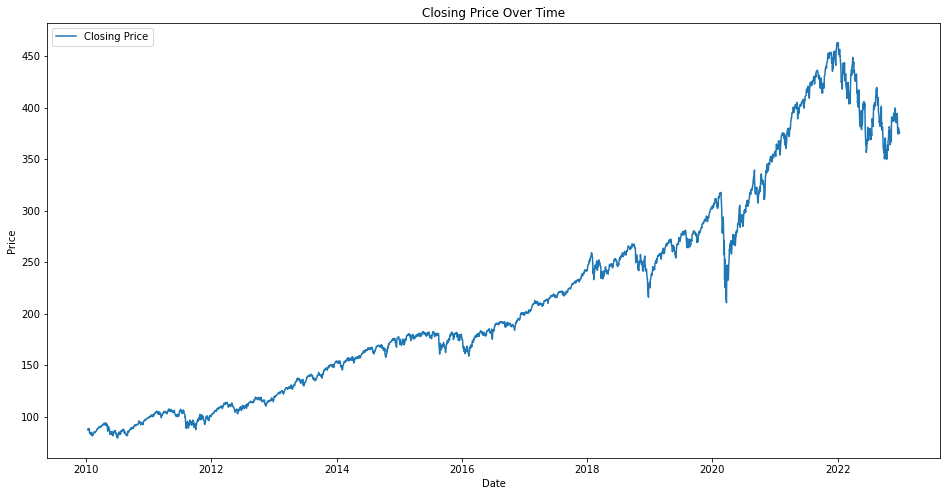

In [66]:


plt.figure(figsize=(16, 8))
plt.plot(data['Adj Close'], label='Closing Price')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [67]:
data['Signal'] = 0
data['Signal'][data['Returns'] > data['MA_Mean']] = 1  # Buy signal
data['Signal'][data['Returns'] < data['MA_Mean']] = -1  # Sell signal

C:\Users\MSI\AppData\Local\Temp\ipykernel_29184\4130772808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'] = 0
C:\Users\MSI\AppData\Local\Temp\ipykernel_29184\4130772808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Returns'] > data['MA_Mean']] = 1  # Buy signal
C:\Users\MSI\AppData\Local\Temp\ipykernel_29184\4130772808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [68]:
initial_investment=100000

Final cash for  trading strategy: $79142.23, Profit: $-20857.77


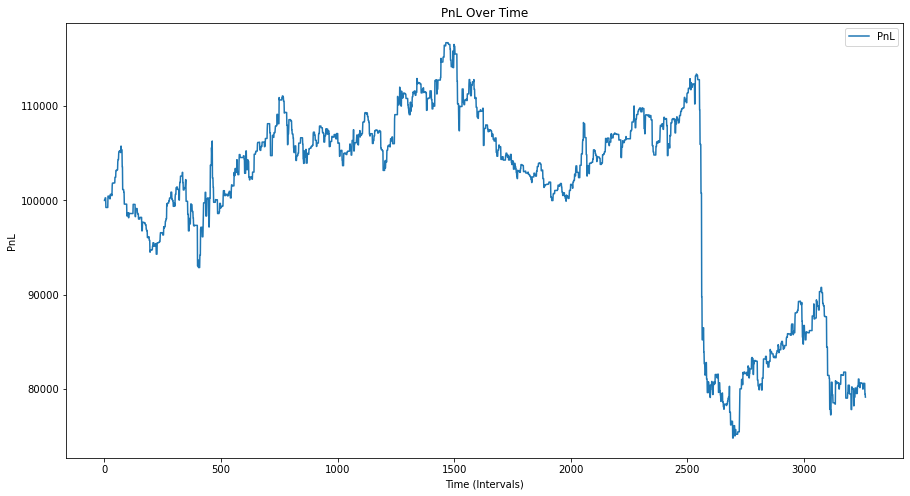

In [69]:
# Function to simulate trades and track PnL
def simulate_trades(stock_prices, signals, initial_investment):
    cash = initial_investment
    stock_held = 0
    transaction_log = []
    pnl = [initial_investment]  # Initialize PnL with initial investment

    for i, signal in enumerate(signals):
        # Buy if the model predicts a 'buy' signal
        if signal == 1 and cash >= stock_prices[i]:
            stock_held = cash // stock_prices[i]
            cash -= stock_held * stock_prices[i]
            transaction_log.append(('BUY', i, stock_held, stock_prices[i]))
            
        # Sell if the model predicts a 'sell' signal and stock is held
        elif signal == -1 and stock_held > 0:
            cash += stock_held * stock_prices[i]
            stock_held = 0
            transaction_log.append(('SELL', i, stock_held, stock_prices[i]))
        
        # Update PnL
        current_value = cash + stock_held * stock_prices[i]
        pnl.append(current_value)

    return pnl, transaction_log

# Run the simulation using the closing prices and the predicted signals
pnl, transactions = simulate_trades(data['Adj Close'], data['Signal'], initial_investment)
final_cash = pnl[-1]
profit = final_cash - initial_investment
print(f"Final cash for  trading strategy: ${final_cash:.2f}, Profit: ${profit:.2f}")
# Plot the PnL 
plt.figure(figsize=(15, 8))
plt.plot(pnl, label='PnL')
plt.title('PnL Over Time')
plt.ylabel('PnL')
plt.xlabel('Time (Intervals)')
plt.legend()
plt.show()

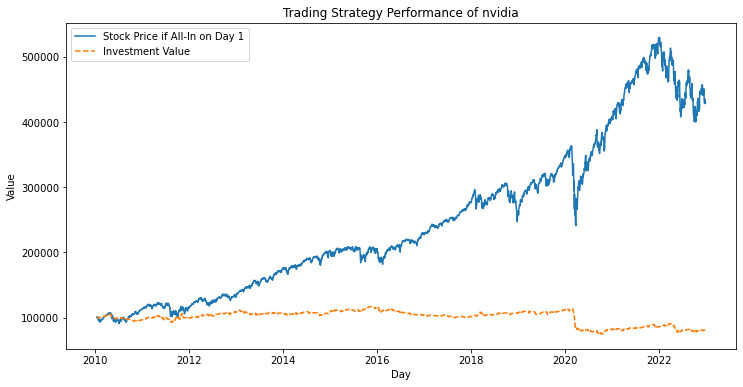

In [70]:
def calculate_cumulative_investment_value(transactions, stock_prices, initial_investment):
    cash = initial_investment
    stock_held = 0
    investment_value = []

    for i, price in enumerate(stock_prices):
        # Execute transactions that occur on this day
        while transactions and transactions[0][1] == i:
            action, _, quantity, _ = transactions.pop(0)
            if action == 'BUY' and cash >= price:
                num_stocks_to_buy = cash // price
                stock_held += num_stocks_to_buy
                cash -= num_stocks_to_buy * price
            elif action == 'SELL' and stock_held > 0:
                cash += stock_held * price
                stock_held = 0

        # Calculate current value of investment
        current_value = cash + stock_held * price
        investment_value.append(current_value)

    return investment_value

cumulative_investment_value = calculate_cumulative_investment_value(transactions, data['Adj Close'], initial_investment)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'].index, data['Adj Close'].values * (initial_investment // data['Adj Close'].iloc[0]), label='Stock Price if All-In on Day 1')
plt.plot(data['Adj Close'].index, cumulative_investment_value, label='Investment Value', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Trading Strategy Performance of nvidia')
plt.legend()
plt.show()

In [71]:
def evaluate_financial_performance1(final_cash, initial_investment, stock_data):
    total_return = (final_cash - initial_investment) / initial_investment
    annualized_return = total_return / (len(stock_data) / 252)  # Assuming 252 trading days in a year

    # Calculating daily returns from stock_data
    daily_returns = stock_data.pct_change()[1:]
    sharpe_ratio = np.mean(daily_returns) / (np.std(daily_returns) * np.sqrt(252))

    return total_return, annualized_return, sharpe_ratio

# Example usage with revised function (assuming nvidia_price and alphabet_price are pandas Series)
total_return, annual_return, sharpe_ratio = evaluate_financial_performance1(final_cash, initial_investment, data['Adj Close'])
print(f" - Total Return: {total_return:.3f}, Annualized Return: {annual_return:.3f}, Sharpe Ratio: {sharpe_ratio:.3f}")

 - Total Return: -0.209, Annualized Return: -0.016, Sharpe Ratio: 0.003


In [72]:
def evaluate_financial_performance2(stock_data, initial_investment):
    # Assuming the investment is done at the start (first entry) and held until the end (last entry)
    final_value = stock_data.iloc[-1] * (initial_investment / stock_data.iloc[0])
    total_return = (final_value - initial_investment) / initial_investment
    annualized_return = total_return / (len(stock_data) / 252)  # Compounded annual growth rate

    # Calculating daily returns from stock_data
    daily_returns = stock_data.pct_change().dropna()
    sharpe_ratio = (daily_returns.mean() ) / (daily_returns.std() * np.sqrt(252))

    return total_return, annualized_return, sharpe_ratio

total_return2, annual_return2, sharpe_ratio2 = evaluate_financial_performance2(data['Adj Close'], initial_investment)
print(f" - Total Return: {total_return2:.3f}, Annualized Return: {annual_return2:.3f}, Sharpe Ratio: {sharpe_ratio2:.3f}")

 - Total Return: 3.299, Annualized Return: 0.255, Sharpe Ratio: 0.003


In [78]:
windows = range(5, 50,2)  # For example, from 1 to 20 days

# Initialize variables to store the best performance metrics
best_total_return = -np.inf
best_windows = (0, 0)

# Grid search
for window1 in windows:
    for window2 in windows:
        if window1 != window2:  # Skip if windows are the same
            # Calculate the moving averages of the returns
            data['MA1'] = data['Returns'].rolling(window=window1).mean()
            data['MA2'] = data['Returns'].rolling(window=window2).mean()

            # Compute the mean of the two moving averages
            data['MA_Mean'] = np.sqrt(data['MA1']**2 + data['MA2']**2)

            # Generate buy/sell signals
            data['Signal'] = 0
            data['Signal'][data['Returns'] > data['MA_Mean']] = 1  # Buy signal
            data['Signal'][data['Returns'] < data['MA_Mean']] = -1  # Sell signal
            
            # Simulate trades based on signals
            pnl, transactions = simulate_trades(data['Adj Close'], data['Signal'], initial_investment)
            final_cash = pnl[-1]
            profit = final_cash - initial_investment

            # Calculate cumulative investment value
            cumulative_investment_value = calculate_cumulative_investment_value(transactions, data['Adj Close'], initial_investment)

            # Evaluate financial performance
            total_return, annual_return, sharpe_ratio = evaluate_financial_performance1(final_cash, initial_investment,data['Adj Close'])

            # Update the best windows if the total return is better
            if total_return > best_total_return:
                best_total_return = total_return
                best_windows = (window1, window2)
                print(f"New best windows: {best_windows} with total return: {best_total_return}")

# Print the best windows and corresponding performance metrics
print(f"Best windows: {best_windows} with total return: {best_total_return}")

C:\Users\MSI\AppData\Local\Temp\ipykernel_29184\3765204481.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Returns'] > data['MA_Mean']] = 1  # Buy signal
C:\Users\MSI\AppData\Local\Temp\ipykernel_29184\3765204481.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][data['Returns'] < data['MA_Mean']] = -1  # Sell signal


New best windows: (5, 7) with total return: 0.27044925926208496
New best windows: (5, 21) with total return: 0.2712132921600342
New best windows: (5, 23) with total return: 0.2921960648345947
New best windows: (5, 25) with total return: 0.2938614501953125
New best windows: (5, 31) with total return: 0.2981033712005615
New best windows: (5, 43) with total return: 0.31816543395996094
New best windows: (5, 47) with total return: 0.3723028508758545
New best windows: (23, 33) with total return: 0.3936393997192383
New best windows: (25, 33) with total return: 0.4209951219177246
New best windows: (27, 29) with total return: 0.480592155380249
New best windows: (27, 31) with total return: 0.571483345489502
New best windows: (27, 33) with total return: 0.6436657987213135
Best windows: (27, 33) with total return: 0.6436657987213135


In [80]:


# Define the ticker symbol and the time frame
ticker_symbol = 'SPY'  # Example for Apple Inc.
start_date_test = '2022-12-28'
end_date_test = '2023-12-28'

# Fetch the historical data
data_test = yf.download(ticker_symbol, start=start_date, end=end_date)

# Calculate daily returns
data_test['Returns'] = data_test['Adj Close'].pct_change()

# Calculate the moving averages of the returns
data_test['MA1'] = data_test['Returns'].rolling(window=27).mean()
data_test['MA2'] = data_test['Returns'].rolling(window=33).mean()

# Compute the mean of the two moving averages
data_test['MA_Mean'] = np.sqrt(data_test['MA1']**2 + data_test['MA2']**2)

data_test['Signal'] = 0
data_test['Signal'][data_test['Returns'] > data_test['MA_Mean']] = 1  # Buy signal
data_test['Signal'][data_test['Returns'] < data_test['MA_Mean']] = -1  # Sell signal

initial_investment=100000


[*********************100%***********************]  1 of 1 completed


C:\Users\MSI\AppData\Local\Temp\ipykernel_29184\3435695207.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Signal'][data_test['Returns'] > data_test['MA_Mean']] = 1  # Buy signal
C:\Users\MSI\AppData\Local\Temp\ipykernel_29184\3435695207.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Signal'][data_test['Returns'] < data_test['MA_Mean']] = -1  # Sell signal


Final cash for  trading strategy: $164133.87, Profit: $64133.87


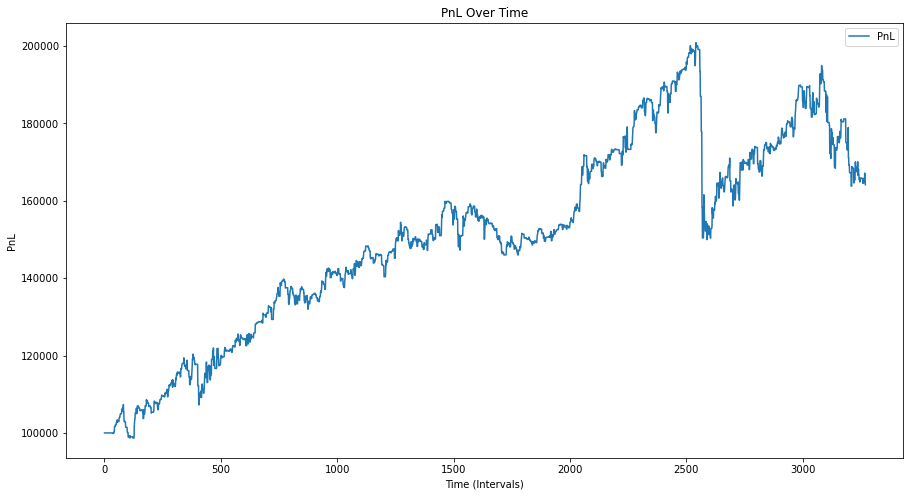

In [81]:
pnl_test, transactions_test = simulate_trades(data_test['Adj Close'], data_test['Signal'], initial_investment)
final_cash_test = pnl_test[-1]
profit_test = final_cash_test - initial_investment
print(f"Final cash for  trading strategy: ${final_cash_test:.2f}, Profit: ${profit_test:.2f}")
# Plot the PnL 
plt.figure(figsize=(15, 8))
plt.plot(pnl_test, label='PnL')
plt.title('PnL Over Time')
plt.ylabel('PnL')
plt.xlabel('Time (Intervals)')
plt.legend()
plt.show()

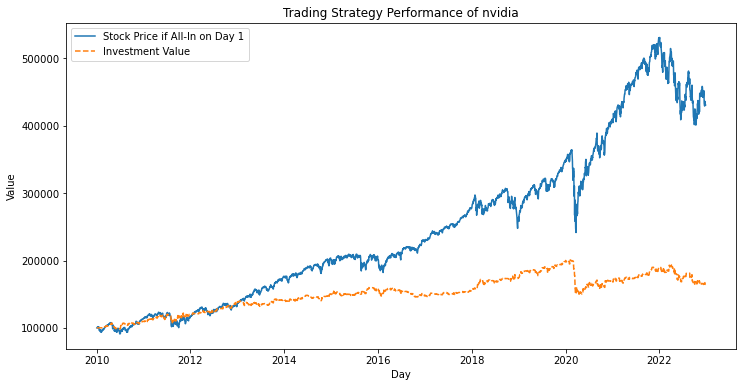

In [82]:
cumulative_investment_value_test = calculate_cumulative_investment_value(transactions_test, data_test['Adj Close'], initial_investment)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data_test['Adj Close'].index, data_test['Adj Close'].values * (initial_investment // data_test['Adj Close'].iloc[0]), label='Stock Price if All-In on Day 1')
plt.plot(data_test['Adj Close'].index, cumulative_investment_value_test, label='Investment Value', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Trading Strategy Performance of nvidia')
plt.legend()
plt.show()

In [84]:
# Example usage with revised function (assuming nvidia_price and alphabet_price are pandas Series)
total_return_test, annual_return_test, sharpe_ratio_test = evaluate_financial_performance1(final_cash_test, initial_investment, data_test['Adj Close'])
print(f"strat - Total Return: {total_return_test:.3f}, Annualized Return: {annual_return_test:.3f}, Sharpe Ratio: {sharpe_ratio_test:.3f}")

total_return2_test, annual_return2_test, sharpe_ratio2_test = evaluate_financial_performance2(data_test['Adj Close'], initial_investment)
print(f"but and hold - Total Return: {total_return2_test:.3f}, Annualized Return: {annual_return2_test:.3f}, Sharpe Ratio: {sharpe_ratio2_test:.3f}")

strat - Total Return: 0.641, Annualized Return: 0.049, Sharpe Ratio: 0.003
but and hold - Total Return: 3.312, Annualized Return: 0.255, Sharpe Ratio: 0.003
